Experiment Summary:
13 subject(s)	 39.0 runs	 85.0 trials/run	 3315.0 total trials
7 points are removed according to Reaction Time.
64 points are removed according to the Error std.
bs_a: 0.3 	95% CI: [-0.72391042  1.28250555]
Von Mise Parameters: amplitude -0.3293, Kai 4.0000.
Half Amplitude: 0.2976
Half Width: 11.4749


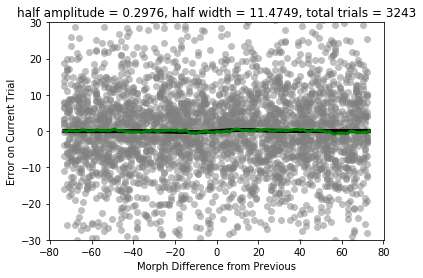

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from util import get_multiFrames

from scipy.optimize import curve_fit
from scipy.special import i0, gamma
from numpy import exp, sin, cos

def vonmise_derivative(xdata, a, kai):
    xdata = xdata / 75 * np.pi
    return - a / (i0(kai) * 2 * np.pi) * exp(kai * cos(xdata)) * kai * sin(xdata) # Derivative of vonmise formula

def Gamma(xdata, a, alpha, beta):
    return a * np.power(beta, alpha) * np.power(xdata, alpha - 1) * exp(-beta * xdata) / gamma(alpha)

def polyFunc(x, coeffs):
    y = 0
    order = len(coeffs)
    for i in range(order):
        y += coeffs[i] * (x ** (order - 1 - i))
    return y

def recenter(x, threshold=73):
    for i in range(len(x)):
        if x[i] > threshold - 1:
            x[i] = x[i] - 2 * threshold
        elif x[i] < -threshold:
            x[i] = x[i] + 2 * threshold
    return x

def getRunningMean(stimuli_diff, filtered_responseError, halfway =75, step = 20):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

def getRegressionLine(x, y, peak):
    stimuli_diff_filtered = []
    filtered_responseError_new = []
    for i in range(len(x)):
        if x[i] < peak + 1 and x[i] > - peak + 1:
            stimuli_diff_filtered.append(x[i])
            filtered_responseError_new.append(y[i])
    coef = np.polyfit(stimuli_diff_filtered,filtered_responseError_new,1)
    poly1d_fn = np.poly1d(coef)
    return poly1d_fn, coef

class Subject:
    def __init__(self, dataFrame, nBack, result_saving_path, RT_threshold=20, std_factors=3, polyfit_order=10, stimulus_maxID=147, trial_num=85, bootstrap=False, permutation=False):
        self.data = dataFrame
        self.nBack = nBack
        self.std_factors = std_factors
        self.RT_threshold = RT_threshold
        self.polyfit_order = polyfit_order
        self.stimulus_maxID = stimulus_maxID
        self.trial_num = trial_num
        self.result_folder = result_saving_path
        self.bootstrap = bootstrap
        self.bsIter = 5000
        self.permutation = permutation
        self.permIter = 5000
        self.peak_x = 18

        self.current_stimuliDiff = []
        self.current_StimLocDiff = []
        self.DoVM_values = []
        self.bootstrap_values = []
        self.RM = []
        self.outSlope = []
        self.outIntercept = []
        self.data['shifted_stimulusID'] = self.data['stimulusID'].shift(-self.nBack)
        self.data['shifted_stimLocationDeg'] = self.data['stimLocationDeg'].shift(-self.nBack)
        self.data['shifted_morphID'] = self.data['morphID'].shift(-self.nBack)
        self.data['RT'] = self.data['RT'].shift(periods=-self.nBack, fill_value=0)
        

    # def toLinear(self):
    #     for i in range(len(self.data['stimulusID'])):
    #         if abs(self.data.loc[i,'morphID'] - self.data.loc[i, 'stimulusID']) >= 80: ## threshold need to change accroding to different patterns
    #             if self.data.loc[i, 'stimulusID'] < self.stimulus_maxID / 2.0:
    #                 self.data.loc[i, 'stimulusID'] += self.stimulus_maxID
    #             else:
    #                 self.data.loc[i, 'stimulusID'] -= self.stimulus_maxID

    # def fromLinear(self):
    #     for i in range(len(self.data['stimulusID'])):
    #         if self.data.loc[i, 'stimulusID'] <= 0:
    #             self.data.loc[i, 'stimulusID'] += self.stimulus_maxID
    #         elif self.data.loc[i, 'stimulusID'] > self.stimulus_maxID:
    #             self.data.loc[i, 'stimulusID'] -= self.stimulus_maxID
    #         else:
    #             continue

    def polyCorrection(self):
        coefs = np.polyfit(self.data['stimulusID'], self.data['morphID'], self.polyfit_order) # polynomial coefs
        self.data['responseError'] = [y - polyFunc(x, coefs) for x,y in zip(self.data['stimulusID'],self.data['morphID'])]
        temp_error = self.data['responseError'].copy()
        self.data['responseError'] = recenter(temp_error)
    
    def polyCorrection_onError(self):
        coefs = np.polyfit(self.data['shifted_stimulusID'], self.data['Error'], self.polyfit_order) # polynomial coefs
        self.data['responseError'] = [y - polyFunc(x, coefs) for x,y in zip(self.data['shifted_stimulusID'],self.data['Error'])]
        #self.data['responseError'] = self.data['Error']
        
    def getnBack_diff(self):
        differencePrevious_stimulusID = []
        differencePrevious_stimulusLoc = []
        filtered_y = []
        filter_RT = []
        for i in range(len(self.data['stimulusID'])):
            if self.data.iloc[i, 5] > self.trial_num - self.nBack:
                continue
            else:
                differencePrevious_stimulusID.append(self.data.iloc[i, 2] - self.data.iloc[i, 9])
                differencePrevious_stimulusLoc.append(self.data.iloc[i, 8] - self.data.iloc[i, 10])
                filtered_y.append(self.data.iloc[i, 13])
                filter_RT.append(self.data.iloc[i, 4])
                
        differencePrevious_stimulusID = recenter(differencePrevious_stimulusID)
        differencePrevious_stimulusLoc = recenter(differencePrevious_stimulusLoc, threshold=180)
        self.current_stimuliDiff = differencePrevious_stimulusID
        self.current_StimLocDiff = differencePrevious_stimulusLoc

        return differencePrevious_stimulusID, differencePrevious_stimulusLoc, filtered_y, filter_RT

    def outlier_removal_RT(self):
        length1 = len(self.data['RT'])
        self.data = self.data[self.data['RT'] <= self.RT_threshold]
        self.data = self.data.reset_index()
        length2 = len(self.data['RT'])
        print('{0:d} points are removed according to Reaction Time.'.format(length1 - length2))

    def error(self):
        self.data['Error'] = [y - x for x, y in zip(self.data['shifted_stimulusID'],self.data['shifted_morphID'])]
        temp_error = self.data['Error'].copy()
        self.data['Error'] = recenter(temp_error)
        self.data.dropna(inplace=True)

    def outlier_removal_SD(self):
        length1 = len(self.data['Error'])
        error_mean = np.mean(self.data['Error'])
        error_std = np.std(self.data['Error'])
        self.data = self.data[self.data['Error'] <= error_mean + self.std_factors * error_std]
        self.data = self.data[self.data['Error'] >= error_mean - self.std_factors * error_std]
        self.data = self.data.reset_index()
        length2 = len(self.data['Error'])
        print('{0:d} points are removed according to the Error std.'.format(length1 - length2))

    def save_RTfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('stimulus ID & Reaction Time')
        plt.xlabel('stimulus ID')
        plt.ylabel('Reaction Time')
        plt.plot(self.data['stimulusID'], self.data['RT'], 'o', color ='orange', alpha=0.5, markersize=10)
        plt.savefig(self.result_folder + filename, dpi=150)
        plt.close()

    def save_SRfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('Stimulus & Response')
        plt.xlabel('Stimulus ID')
        plt.ylabel('Morph Response')
        plt.axhline(y=75, linewidth=4, linestyle = "--", color='b', label = 'y = 75' )
        plt.plot(self.data['stimulusID'], self.data['stimulusID'], linewidth=4, linestyle = "-", color='g', label = 'x = y')
        plt.plot(self.data['stimulusID'], self.data['morphID'], 'mo', alpha=0.5, markersize=10)
        plt.savefig(self.result_folder + filename, dpi=150)
        plt.close()

    def save_Polyfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('Stimulus & Response')
        plt.xlabel('Stimulus ID')
        plt.ylabel('Morph Response')
        plt.axhline(y=75, linewidth=4, linestyle = "--", color='b', label = 'y = 75' )
        plt.plot(self.data['stimulusID'], self.data['stimulusID'], linewidth=4, linestyle = "-", color='g', label = 'x = y')
        plt.plot(self.data['stimulusID'], self.data['morphID'], 'mo', alpha=0.5, markersize=10)
        coefs = np.polyfit(self.data['stimulusID'], self.data['morphID'], self.polyfit_order)
        xarray = np.array(range(-30, 170 + 1))
        PolyLine = np.polyval(coefs, xarray)
        plt.plot(xarray, PolyLine, label = 'poly', color = 'c', linewidth = 3)
        plt.savefig(self.result_folder + filename, dpi=150)
        plt.close()

    def save_Errorfigure(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('Stimulus &Error')
        plt.xlabel('Stimulus ID')
        plt.ylabel('Error')
        plt.xlim(-20, 170)
        plt.ylim(-60, 60)
        plt.axhline(y=0, linewidth=4, linestyle = "--", color='b', label = 'y = 0' )
        plt.plot(self.data['stimulusID'], self.data['Error'], 'mo', alpha=0.5, markersize=10)
        plt.savefig(self.result_folder + filename, dpi=150)
        plt.close()

    def save_Errorfigure2(self, filename):
        plt.figure()
        plt.rcParams["figure.figsize"] = (10,6)
        plt.rcParams.update({'font.size': 22})
        plt.title('Stimulus & Response Error after Bias Removal')
        plt.xlabel('Stimulus ID')
        plt.ylabel('Response Error')
        plt.xlim(-20, 170)
        plt.ylim(-60, 60)
        plt.axhline(y=0, linewidth=4, linestyle = "--", color='b', label = 'y = 0' )
        plt.plot(self.data['stimulusID'], self.data['responseError'], 'mo', alpha=0.5, markersize=10)
        plt.savefig(self.result_folder + filename, dpi=150)
        plt.close()

    def add_column(self, column_data, column_name):
        self.data[column_name] = column_data

    def Extract_currentCSV(self, fileName):
        ## FileName: SubjectName_nBack_outlierRemoveornot
        ## Delete rows
        output_data = self.data.copy(deep=True)
        
        for i in range(nBack):
            output_data = output_data[output_data['trialNumber'] != self.trial_num - i]
        
        output_data['Stim_diff'] = self.current_stimuliDiff
        output_data['Stim_Loc_diff'] = self.current_StimLocDiff
        df = pd.DataFrame({'bootstrap_values':np.array(self.bootstrap_values)})
        df1 = pd.DataFrame({'Running_Mean':np.array(self.RM)})
        df2 = pd.DataFrame({'slopes':np.array(self.outSlope)})
        df3 = pd.DataFrame({'intercepts':np.array(self.outIntercept)})
        df4 = pd.DataFrame({'DoVM':np.array(self.DoVM_values)})
        output_data = pd.concat([output_data, df, df1, df2, df3, df4], axis=1)
        del output_data['level_0']
        del output_data['index']
        del output_data['blockType']
        output_data.to_csv(self.result_folder + fileName, index=False, header=True)
    
    def CurvefitFunc(self, x, y, func=vonmise_derivative, init_vals=[-25, 4], bounds_input = ([-60,2],[60, 4])):
        best_vals, covar = curve_fit(func, x, y, p0=init_vals, bounds = bounds_input)
        return best_vals
    
    def VonMise_BinFitting(self, xRaw, yRaw, x_range, LocationDiff):
#         mean_results = []
#         std_results = []
        x_bin1 = []
        y_bin1 = []
        for j, temp_LocationDiff in enumerate(LocationDiff):
            if abs(temp_LocationDiff) > 0 * 90 and abs(temp_LocationDiff) < (0 + 1) * 90:
                x_bin1.append(xRaw[j])
                y_bin1.append(yRaw[j])
        RandIndex = np.random.choice(len(x_bin1), 100, replace=True) # get randi index of xdata
        x_bin1 = [x_bin1[i] for i in RandIndex] # change xdata index
        y_bin1 = [y_bin1[i] for i in RandIndex] # change ydata index

        x_bin2 = []
        y_bin2 = []
        for j, temp_LocationDiff in enumerate(LocationDiff):
            if abs(temp_LocationDiff) > 1 * 90 and abs(temp_LocationDiff) < (1 + 1) * 90:
                x_bin2.append(xRaw[j])
                y_bin2.append(yRaw[j])
        RandIndex = np.random.choice(len(x_bin2), 100, replace=True) # get randi index of xdata
        x_bin2 = [x_bin2[i] for i in RandIndex] # change xdata index
        y_bin2 = [y_bin2[i] for i in RandIndex] # change ydata index
        
        return x_bin1, y_bin1, x_bin2, y_bin2
            
        
#         for i in range(2):
#             x = []
#             y = []
#             for j, temp_LocationDiff in enumerate(LocationDiff):
#                 if abs(temp_LocationDiff) > i * 90 and abs(temp_LocationDiff) < (i + 1) * 90:
#                     x.append(xRaw[j])
#                     y.append(yRaw[j])
#             RandIndex = np.random.choice(len(x), 100, replace=True) # get randi index of xdata
#             xdataNEW = [x[i] for i in RandIndex] # change xdata index
#             ydataNEW = [y[i] for i in RandIndex] # change ydata index
#             bootstraps = self.VonMise_fitting(xdataNEW, ydataNEW, 75)
#             mean_temp = round(np.mean(bootstraps), 2)
#             mean_results.append(mean_temp)
#             std_temp = round(np.std(bootstraps), 2)
#             std_results.append(std_temp)
#             print( "bin size =" + str(len(xdataNEW)))
#             print("bin amplitude = " + str(mean_temp))
#             print("bin std = " + str(std_temp))
#             print("\n")
#         return mean_results, std_results

    def VonMise_fitting(self, x, y, x_range, func=vonmise_derivative, init_vals=[-25, 4],  bounds_input = ([-60,2],[60,4])):
        best_vals = self.CurvefitFunc(x, y, init_vals=init_vals, bounds_input = bounds_input)

        if self.bootstrap:
            OutA = [] # Output a array, store each trial's a
            outSlope = []
            outIntercept = []
            bsSize = int(1.0 * len(x))
            for i in range(self.bsIter):
                RandIndex = np.random.choice(len(x), bsSize, replace=True) # get randi index of xdata
                xdataNEW = [x[i] for i in RandIndex] # change xdata index
                ydataNEW = [y[i] for i in RandIndex] # change ydata index
                try:
                    temp_best_vals = self.CurvefitFunc(xdataNEW, ydataNEW, init_vals=init_vals, bounds_input=bounds_input)
                    new_x = np.linspace(-x_range, x_range, 300)
                    new_y = [vonmise_derivative(xi,temp_best_vals[0],temp_best_vals[1]) for xi in new_x]
                    if new_x[np.argmax(new_y)] > 0: 
                        OutA.append(np.max(new_y))
                    else: 
                        OutA.append(-np.max(new_y))
                    
                    poly1d_fn, coef = getRegressionLine(xdataNEW, ydataNEW, self.peak_x)
                    outSlope.append(coef[0])
                    outIntercept.append(coef[1])
                except RuntimeError:
                    pass
            print("bs_a:",round(np.mean(OutA),2),"	95% CI:",np.percentile(OutA,[2.5,97.5]))
            self.bootstrap_values = OutA  ###ADD ME BACK YO
            self.outSlope = outSlope
            self.outIntercept = outIntercept
            # np.save(self.result_folder + 'bootstrap.npy', OutA)
            
        if self.permutation:
            # perm_a, perm_b = repeate_sampling('perm', xdata, ydata, CurvefitFunc, size = permSize)
            OutB = [] # Output a array, store each trial's a
            perm_xdata = x
            for i in range(self.permIter):
                perm_xdata = np.random.permutation(perm_xdata) # permutate nonlocal xdata to update, don't change ydata
                try:
                    temp_best_vals = self.CurvefitFunc(perm_xdata, y, init_vals=init_vals, bounds_input=bounds_input) # permutation make a sample * range(size) times
                    new_x = np.linspace(-x_range, x_range, 300)
                    new_y = [vonmise_derivative(xi,temp_best_vals[0],temp_best_vals[1]) for xi in new_x]
                    if new_x[np.argmax(new_y)] > 0: 
                        OutB.append(np.max(new_y))
                    else: 
                        OutB.append(-np.max(new_y))
                except RuntimeError:
                    pass
            print("perm_a:",round(np.mean(OutB),2),"	90% CI:",np.percentile(OutB,[5,95]))

        print('Von Mise Parameters: amplitude {0:.4f}, Kai {1:.4f}.'.format(best_vals[0],best_vals[1]))
        return best_vals, outSlope, outIntercept
        #return OutA ###TAKE OUT OUTA YO


    def save_DerivativeVonMisesFigure(self, xlabel_name, filename, x, y, x_range, best_vals):
        plt.figure()
        plt.ylim(-30, 30) #(-40, 40)
        #plt.title("Derivative Von Mises n Trials Back")
        plt.xlabel(xlabel_name)
        plt.ylabel('Error on Current Trial')
        plt.plot(x, y, marker ='o', color= '#808080', ls = '', alpha=0.5, markersize=7, markeredgewidth=0.0)
        new_x = np.linspace(-x_range, x_range, 300)
        new_y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in new_x]
        second_x = np.linspace(-x_range, x_range, 147)
        DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in second_x]
        self.DoVM_values = DoVM_values
        plt.plot(new_x, new_y, 'k-', linewidth = 4)
        #### RUNNING MEAN ####
        RM, xvals = getRunningMean(x, y, halfway=x_range)
        self.RM = RM
        plt.plot(xvals, RM, label = 'Running Mean', color = 'g', linewidth = 3)
        peak_x = (new_x[np.argmax(new_y)])
        # poly1d_fn, coef = getRegressionLine(x, y, peak_x)
        # xdata = np.linspace(-peak_x, peak_x, 100)
        # plt.plot(xdata, poly1d_fn(xdata), '--r', linewidth = 2)
        # print(coef[0], coef[1])
        if new_x[np.argmax(new_y)] > 0:
            plt.title("half amplitude = {0:.4f}, half width = {1:.4f}, total trials = {2:d}". format(np.max(new_y), new_x[np.argmax(new_y)], len(x)))
        else: 
            plt.title("half amplitude = {0:.4f}, half width = {1:.4f}, total trials = {2:d}". format(-np.max(new_y), -new_x[np.argmax(new_y)], len(x)))
        plt.savefig(self.result_folder + filename, dpi=1200)


        print('Half Amplitude: {0:.4f}'.format(np.max(new_y)))
        print('Half Width: {0:.4f}'.format(new_x[np.argmax(new_y)]))

def save_TrialsBack_RT_Figure(x, y, x_range, xlabel_name, filename):
    plt.figure()
    plt.title("Trials Back and Reaction Time")
    plt.xlabel(xlabel_name)
    plt.ylabel('RT on Current Trial')
    plt.plot(x, y, 'co', alpha=0.5, markersize=10)
    x = np.linspace(-x_range, x_range, 300)
    plt.savefig(filename, dpi=150)
    plt.close()

if __name__ == "__main__":
    ### Read data ###
    path = './' ## the folder path containing all experiment csv files
    data, dataList, subjectList = get_multiFrames(path)
    results_path = './results/'

    ## Loop through every subjects ##
#     x_bin1 = [] 
#     y_bin1 = []
#     x_bin2 = []
#     y_bin2 = []
    #for i in range(len(dataList)):

    #temp_filename, _ = os.path.splitext(subjectList[i])
    #prefix = temp_filename.split('_')[0]
    prefix = 'SuperSubject'

    result_saving_path = results_path + prefix + '/'
    os.mkdir(result_saving_path)

    ## Loop through every trial back up to 3 ##
    for j in range(3):
            #j = -2 ### change this to change the num of trials back

            nBack = j + 1
            result_saving_path_figure = prefix + '_VM_Figure_' + str(nBack) + 'nBack.pdf'
            result_saving_path_outputcsv = prefix + '_VM_output_' + str(nBack) + 'nBack.csv'
            # os.mkdir(result_saving_path)

            ### Initialize a subject ###List[i] 
            subject = Subject(data, nBack, result_saving_path, bootstrap=True, permutation=False)

                #subject.save_RTfigure('ReactionTime.pdf')
            subject.outlier_removal_RT()
            #subject.save_RTfigure('ReactionTime_OutlierRemoved.pdf')
            #subject.save_SRfigure('RawData.pdf')

            ### Polynomial Correction ###
            # subject.toLinear()
            # subject.save_SRfigure('CorrectedData.pdf')
            subject.error()
            #subject.save_Errorfigure('RawError.pdf')
            subject.outlier_removal_SD()
            #subject.save_Errorfigure('ErrorResponse_OutlierRemoved.pdf')
            subject.polyCorrection_onError()
            # subject.save_Polyfigure('PolyFit.pdf')
            # subject.fromLinear()
            #subject.save_Errorfigure2('BiasRemoved.pdf')

            ## Compute the stimulus difference ##
            stimuli_diff, loc_diff, filtered_responseError, filtered_RT = subject.getnBack_diff()

            # ## Von Mise fitting: Shape Similarity##
            best_vals, outSlope, outIntercept = subject.VonMise_fitting(stimuli_diff, filtered_responseError, 73)
    #         temp_x_bin1, temp_y_bin1, temp_x_bin2, temp_y_bin2 = subject.VonMise_BinFitting(stimuli_diff, filtered_responseError, 75, loc_diff)
    #         x_bin1 = x_bin1 + temp_x_bin1
    #         y_bin1 = y_bin1 + temp_y_bin1
    #         x_bin2 = x_bin2 + temp_x_bin2
    #         y_bin2 = y_bin2 + temp_y_bin2
    # #             print("Bin amplitudes:")
    # #             print(mean_results)
    # #             print("Bin stds:")
    # #             print(std_results)
            subject.save_DerivativeVonMisesFigure('Morph Difference from Previous', result_saving_path_figure, stimuli_diff, filtered_responseError, 73, best_vals)

            #### Extract CSV ####
            subject.Extract_currentCSV(result_saving_path_outputcsv)

            ## Trials back and Reaction Time for Shape##
            # save_TrialsBack_RT_Figure(stimuli_diff, filtered_RT, 75, 'Morph Difference from Previous', result_saving_path + 'TrialsBack_RT_Shape.pdf')

            ## Von Mise fitting: Location Similarity##
            # best_vals = subject.VonMise_fitting(loc_diff, filtered_responseError)
            # subject.save_DerivativeVonMisesFigure('Angle Location Difference from Previous', 'LocationDiff_DerivativeVonMises.pdf', loc_diff, filtered_responseError, 180, best_vals)

            ## Trials back and Reaction Time for Location##
            # save_TrialsBack_RT_Figure(loc_diff, filtered_RT, 180, 'Location Difference from Previous', result_saving_path + 'TrialsBack_RT_Location.pdf')
    #     bootstraps = subject.VonMise_fitting(x_bin1, y_bin1, 75)
    #     mean_temp = round(np.mean(bootstraps), 2)
    #     CI_temp = np.percentile(bootstraps,[2.5,97.5])
    #     print("bin amplitude = " + str(mean_temp))
    #     print("bin CI = " + str(CI_temp))
    #     print("\n")

    #     bootstraps = subject.VonMise_fitting(x_bin2, y_bin2, 75)
    #     mean_temp = round(np.mean(bootstraps), 2)
    #     CI_temp = np.percentile(bootstraps,[2.5,97.5])
    #     print("bin amplitude = " + str(mean_temp))
    #     print("bin CI = " + str(CI_temp))
    #     print("\n")